In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

data = pd.read_csv('../data/healthcare-dataset-stroke-data.csv')
data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


### Exploratory Data Analysis

There are four types of smoking statuses: Unknown, formerly smoked, never smoked, and smokes.

In [53]:
data.groupby('smoking_status').size()

smoking_status
Unknown            1544
formerly smoked     885
never smoked       1892
smokes              789
dtype: int64

Also, there are five types of work: goverment job, never worked, private, self-employed, and children. Along with two types of residences: rural and urban.

In [54]:
data.groupby('work_type').size()

work_type
Govt_job          657
Never_worked       22
Private          2925
Self-employed     819
children          687
dtype: int64

In [55]:
data.groupby('Residence_type').size()

Residence_type
Rural    2514
Urban    2596
dtype: int64

We can check for any null values in our data.

In [56]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

Let's make a scatterplot to visualize the relationship between age and average glucose level.

<AxesSubplot:xlabel='age', ylabel='avg_glucose_level'>

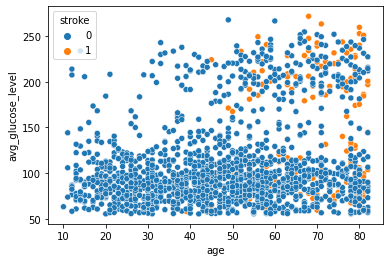

In [4]:
sns.scatterplot(data=data.head(1700), x='age', y='avg_glucose_level', hue='stroke')

Notice that people who had strokes were of ages between 40 to 80 with an average glucose level ranging from 100 to 250.

Even though we only used 1,700 data points, our scatterplot is very cluttered. We will use a contour plot for a clearer view of the data in its entirety.

<AxesSubplot:xlabel='age', ylabel='avg_glucose_level'>

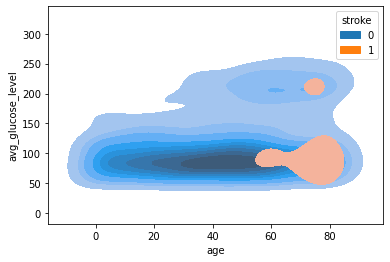

In [58]:
sns.kdeplot(
    data=data, x='age', y='avg_glucose_level', hue='stroke', fill=True
)

We see that age can be a factor of having a stroke from the visualization above.

<AxesSubplot:xlabel='age', ylabel='bmi'>

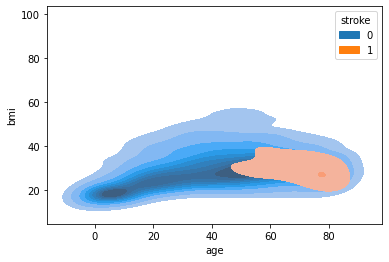

In [60]:
sns.kdeplot(
    data=data, x='age', y='bmi', hue='stroke', fill=True
)

<AxesSubplot:xlabel='smoking_status', ylabel='age'>

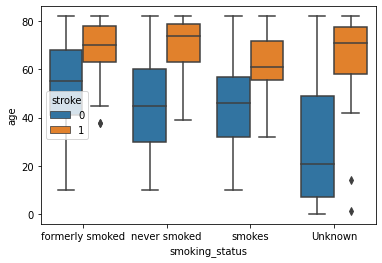

In [61]:
sns.boxplot(x='smoking_status', y='age', hue='stroke', data=data)

<AxesSubplot:xlabel='smoking_status', ylabel='avg_glucose_level'>

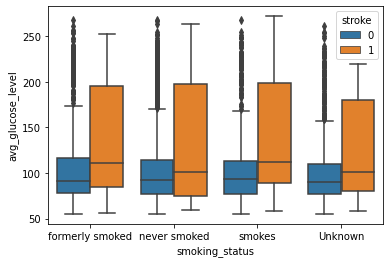

In [62]:
sns.boxplot(x='smoking_status', y='avg_glucose_level', hue='stroke', data=data)

We see that age and average glucose level are most likely good predictors for a stroke.

<AxesSubplot:xlabel='bmi', ylabel='avg_glucose_level'>

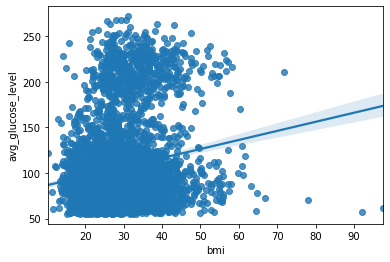

In [67]:
sns.regplot(data=data, x='bmi', y='avg_glucose_level')

In [10]:
data.groupby('work_type').count().index

Index(['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'], dtype='object', name='work_type')

### Data Cleaning and Processing

In order to build our logistic regression model, we must transform our data into numerical values. We can do that using one-hot encoding through our ETL pipeline.

In [33]:
import sys
sys.path.insert(0, '../jobs')

In [34]:
import etl_job as etl

In [35]:
df = etl.start()

+----+------------+-------------+-----------------+------+------------+-------------+--------------+---------------+
| age|hypertension|heart_disease|avg_glucose_level|gender|ever_married|    work_type|Residence_type| smoking_status|
+----+------------+-------------+-----------------+------+------------+-------------+--------------+---------------+
|67.0|         0.0|          1.0|           228.69|  male|         yes|      private|         urban|formerly smoked|
|61.0|         0.0|          0.0|           202.21|female|         yes|self-employed|         rural|   never smoked|
|80.0|         0.0|          1.0|           105.92|  male|         yes|      private|         rural|   never smoked|
|49.0|         0.0|          0.0|           171.23|female|         yes|      private|         urban|         smokes|
|79.0|         1.0|          0.0|           174.12|female|         yes|self-employed|         rural|   never smoked|
|81.0|         0.0|          0.0|           186.21|  male|      

In [38]:
df
df.features.to_list()

[array([ 67.  ,   0.  ,   1.  , 228.69,   0.  ,   1.  ,   1.  ,   1.  ,
          0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   1.  ]),
 array([ 61.  ,   0.  ,   0.  , 202.21,   1.  ,   0.  ,   1.  ,   0.  ,
          1.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ]),
 array([ 80.  ,   0.  ,   1.  , 105.92,   0.  ,   1.  ,   1.  ,   1.  ,
          0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ]),
 array([ 49.  ,   0.  ,   0.  , 171.23,   1.  ,   0.  ,   1.  ,   1.  ,
          0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   0.  ]),
 array([ 79.  ,   1.  ,   0.  , 174.12,   1.  ,   0.  ,   1.  ,   0.  ,
          1.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ]),
 array([ 81.  ,   0.  ,   0.  , 186.21,   0.  ,   1.  ,   1.  ,   1.  ,
          0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,   1.  ]),
 array([74.  ,  1.  ,  1.  , 70.09,  0.  ,  1.  ,  1.  ,  1.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ]),
 array([69.  ,  0.  ,  0.  , 94.39,  1.  ,  0.  ,

In [39]:
df = pd.DataFrame(df.features.to_list(), columns=range(len(df['features'][0])))
df


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,67.0,0.0,1.0,228.69,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,61.0,0.0,0.0,202.21,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,80.0,0.0,1.0,105.92,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,49.0,0.0,0.0,171.23,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,79.0,1.0,0.0,174.12,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80.0,1.0,0.0,83.75,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5106,81.0,0.0,0.0,125.20,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
5107,35.0,0.0,0.0,82.99,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5108,51.0,0.0,0.0,166.29,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Building the Logistic Regression Model

In [31]:
model = LogisticRegression(max_iter=5000)

df['stroke'] = data['stroke']

train, test = train_test_split(df, test_size=0.10, random_state=42)

X_train, y_train = train.iloc[:,:len(df.columns)-1], train['stroke']
X_test, y_test = test.iloc[:,:len(df.columns)-1], test['stroke']

In [32]:
model.fit(X_train, y_train)
predictions = model.predict(X_train)
print(predictions)
print('Training Accuracy: ', model.score(X_train, y_train))
print('Test Accuracy: ', model.score(X_test, y_test))

[0 0 0 ... 0 0 0]
Training Accuracy:  0.9521635138073494
Test Accuracy:  0.9452054794520548


In [ ]:
95.22
94.52